# Robust Workflow

This workflow contains a new function `process_data_steam()` that allows a user to process DataStreams that are not stationary if they choose to do so by setting the flag `operate_safe = False`. With this flag set to False, if a DataStream is not stationary, the code will return the mean based on the last 33% of the data, with an uncertainty of 100%. The dictionary of results that is returned also contains metadata to indicate if the DataStream was processed normally, or if there were exceptions (such as non-stationarity), and how those were mitigated.

This workflow may get added to the QUENDS base class after further testing and refinement.




## Import Required Libraries and Helper Functions

In [5]:
# Import required libraries
import numpy as np
import quends as qnds
import pprint
import matplotlib.pyplot as plt

# Custom class to specify formatting of floats (and tuples of floats) in pprint 
# and limit the number of significant digits in results dictionaries printed to screen
class FloatFormatter(pprint.PrettyPrinter):
    def _format(self, object, stream, indent, allowance, context, level):
        if isinstance(object, tuple):
            stream.write('(')
            for i, item in enumerate(object):
                if isinstance(item, float):
                    stream.write(format(item, '.4g'))
                else:
                    super()._format(item, stream, indent, allowance, context, level)
                if i < len(object) - 1:
                    stream.write(', ')
            stream.write(')')
        elif isinstance(object, float):
            stream.write(format(object, '.4g'))
        else:
            super()._format(object, stream, indent, allowance, context, level)

# use as 'formatter.pprint(object)'
formatter = FloatFormatter(indent=0)


# New function to process a data stream with more options to handle exceptions
def process_data_steam(data_stream, col, operate_safe=True, trim_window_size=50, trim_method="rolling_variance", trim_threshold=0.5, start_time=0.0):
    """
    Process data_stream and handle exceptions gracefully.
    Return mean value and its statistics

    Todo: 
    * provide way to send in more options for trimming etc.
    * look at number of effective samples we have. Could be low. Allow user to override this if they want minimum # of samples for analysis. 
    """

    # Check if data stream is stationary
    stationary = data_stream.is_stationary([col])[col] # is_stationary() returns dictionary. the value for key qoi tells us if it is stationary

    if stationary:
        # Trim
        trimmed_stream = data_stream.trim(column_name=col, batch_size=trim_window_size, method=trim_method, threshold=trim_threshold, start_time=start_time)

        # Start of statistical steady state
        sss_start = trimmed_stream.df['time'][0]

        # Get statistics (with window selected by decorrelation length)
        trimmed_stats = trimmed_stream.compute_statistics(column_name=col)

        # Add flag for the results for this qoi that all is normal
        trimmed_stats[col]["sss_start"] = sss_start
        trimmed_stats[col]["metadata"] = {}
        trimmed_stats[col]["metadata"]["status"] = "normal"
        trimmed_stats[col]["metadata"]["mitigation"] = "none"

        return trimmed_stats


    elif operate_safe: # Not stationary and we want to operate safely
        # Do not process and return non-stationary flag
        results_dict = {}
        results_dict[col] = {}
        results_dict[col]["mean"] = np.nan
        results_dict[col]["mean_uncertainty"] = np.nan
        results_dict[col]["confidence_interval"] = (np.nan, np.nan)
        results_dict[col]["sss_start"] = np.nan
        results_dict[col]["metadata"] = {}
        results_dict[col]["metadata"]["status"] = "nonstationary"
        results_dict[col]["metadata"]["mitigation"] = "drop"

        return results_dict
    
    else: # not stationary but we want to get some result back

        # Return ad-hoc mean based on last 33% of data and arbitrarily large uncertainties/confidence interval
        results_dict = {}
        results_dict[col] = {}

        # Get the data
        column_data = data_stream.df[col].dropna()

        # Compute index for 2/3rds of the data set
        n_pts = len(column_data)
        n_66pc = (n_pts*2)//3
        
        # Get ad hoc statistics
        mean_val = np.mean(column_data[n_66pc:])
        uncertainty_val = mean_val # Arbitrary 100% uncertainty
        # For confidence interval, assume the true value is somewhere between 0 and twice the mean.
        ci_lower = mean_val - uncertainty_val
        ci_upper = mean_val + uncertainty_val

        # Store results in dictionary and return
        results_dict[col]["mean"] = mean_val
        results_dict[col]["mean_uncertainty"] = uncertainty_val
        results_dict[col]["confidence_interval"] = (ci_lower, ci_upper)
        results_dict[col]["sss_start"] = data_stream.df.iloc[n_66pc]["time"]
        results_dict[col]["metadata"] = {}
        results_dict[col]["metadata"]["status"] = "nonstationary"
        results_dict[col]["metadata"]["mitigation"] = "adhoc"

        return results_dict
    
# New function to plot signal with basic stats
def plot_signal_basic_stats(data_stream, col, stats, label=None):
    """
    data_stream: full Data Stream
    col: string with label of variable we are processing
    stats: dictionary with statistics returned by process_data_steam()
    label: label to use in title of graph
    """

    my_df = data_stream.df

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(my_df["time"],my_df[col], label="Signal")

    ax.set_xlabel("time", size=12)
    ax.set_ylabel(col, size=12)
    if label:
        ax.set_title(label, size=14)
    # Set the font size for the axis tick labels
    ax.tick_params(axis='both', labelsize=11)

    # add the start of steady state and the mean
    my_mean = stats[col]["mean"]
    my_cl = stats[col]["confidence_interval"]
    my_sss_start = stats[col]["sss_start"]
    plt.axvline(x=my_sss_start, color='r', linestyle='--', label="Start SSS")
    
    sss_time = [my_sss_start,my_df.iloc[-1]["time"]]
    mean_level = [my_mean, my_mean]
    upper_conf_level = [my_cl[1],my_cl[1]]
    lower_conf_level = [my_cl[0],my_cl[0]]
    ax.plot(sss_time,mean_level, color='green', linestyle='-', label="Mean")
    ax.plot(sss_time,upper_conf_level, color='green', linestyle='--', label="95% Conf. Int.")
    ax.plot(sss_time,lower_conf_level, color='green', linestyle='--')
    ax.legend(fontsize=12)


## Paths to data files

In [2]:
# Specify the file paths, and include one file that is deliberately not stationary
data_paths = ["./cgyro/output_nu0_02.csv", "./cgyro/output_nu0_05.csv", "./testdata/non-stat.csv", "./cgyro/output_nu0_10.csv", "./cgyro/output_nu0_50.csv", "./cgyro/output_nu1_0.csv"]

# Load one data file to see what variables they contain.
# Assume all files have the same variables in them
data_stream = qnds.from_csv(data_paths[0])
data_vars = data_stream.variables()
print("The data stream contains the following variables:")
for column, name in enumerate(data_vars):
    print(f"{column}: {name}")

col = data_vars[2] # work with first variable (stored after index and time)


The data stream contains the following variables:
0: Unnamed: 0
1: time
2: Q_D/Q_GBD
3: Q_e/Q_GBD


## Process Files

In [3]:
# check stationarity, just for our information
print("Data Path                  , Stationary?")
print("----------------------------------------")
for data_path in data_paths:
    # Load the data into a data_stream object
    data_stream = qnds.from_csv(data_path)

    # Check whether the qoi is stationary
    stationarity_results = data_stream.is_stationary([col])
    print(f"{data_path:27}, {stationarity_results[col]}")        
    

Data Path                  , Stationary?
----------------------------------------
./cgyro/output_nu0_02.csv  , True
./cgyro/output_nu0_05.csv  , True
./testdata/non-stat.csv    , False
./cgyro/output_nu0_10.csv  , True
./cgyro/output_nu0_50.csv  , True
./cgyro/output_nu1_0.csv   , True


Results for ./cgyro/output_nu0_02.csv:
{'Q_D/Q_GBD': {'confidence_interval': (34.88, 40.4),
             'effective_sample_size': 24,
             'mean': 37.64,
             'mean_uncertainty': 1.41,
             'metadata': {'mitigation': 'none', 'status': 'normal'},
             'pm_std': (36.23, 39.05),
             'sss_start': 162.5,
             'window_size': 49},
'metadata': [{'operation': 'is_stationary', 'options': {'columns': 'Q_D/Q_GBD'}},
            {'operation': 'trim',
            'options': {'batch_size': 50,
                       'column_name': 'Q_D/Q_GBD',
                       'method': 'rolling_variance',
                       'robust': True,
                       'sss_start': 162.5,
                       'start_time': 0,
                       'threshold': 0.5}},
            {'operation': 'effective_sample_size',
            'options': {'alpha': 0.05, 'column_names': 'Q_D/Q_GBD'}},
            {'operation': 'compute_statistics',
            'options': {'colu

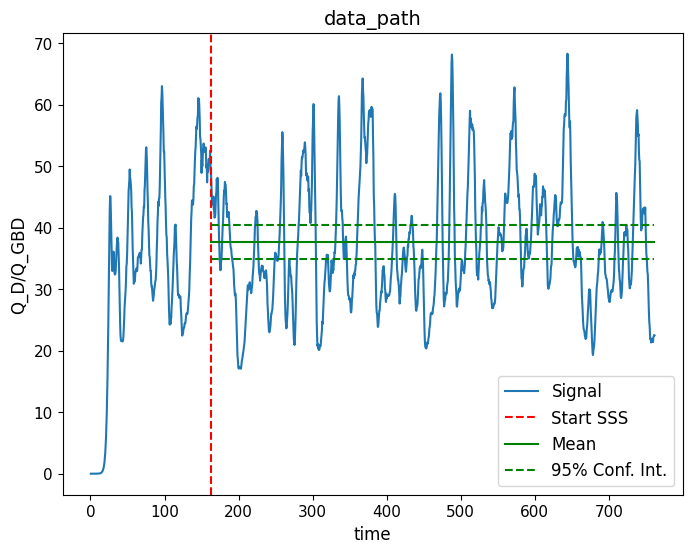

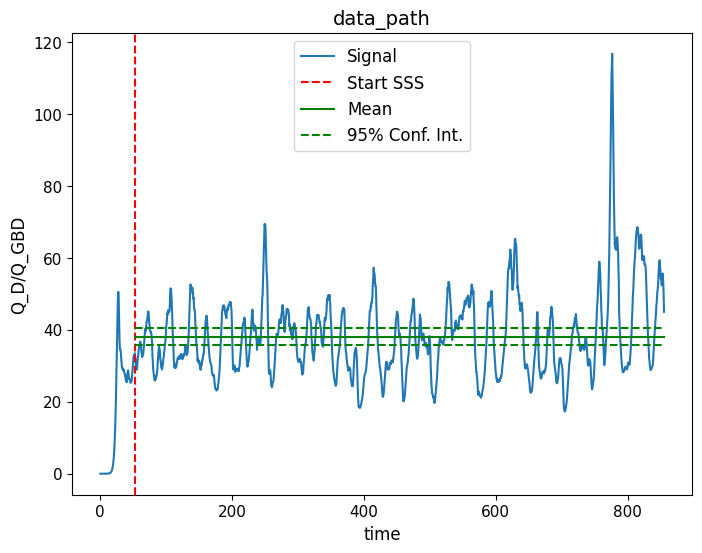

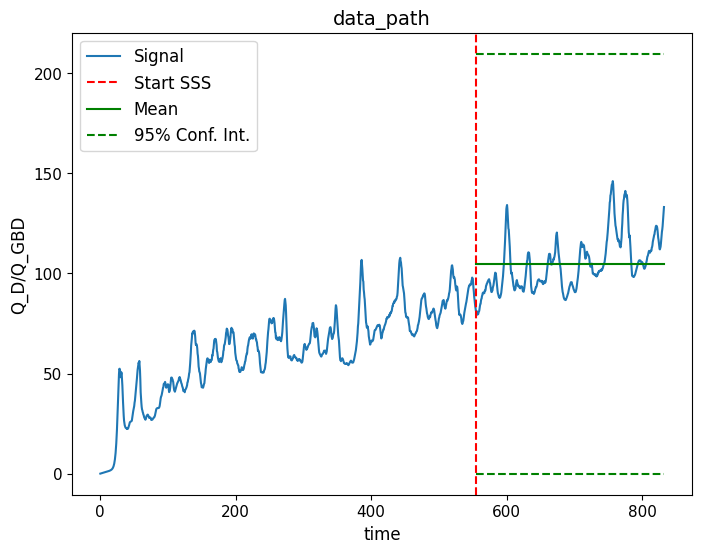

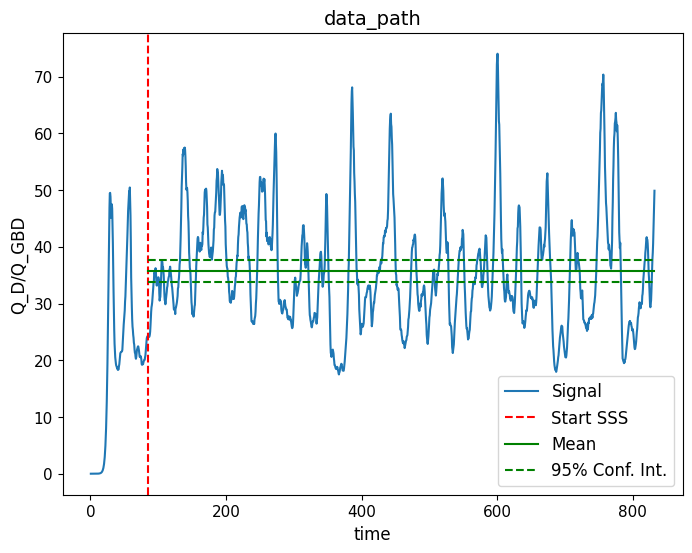

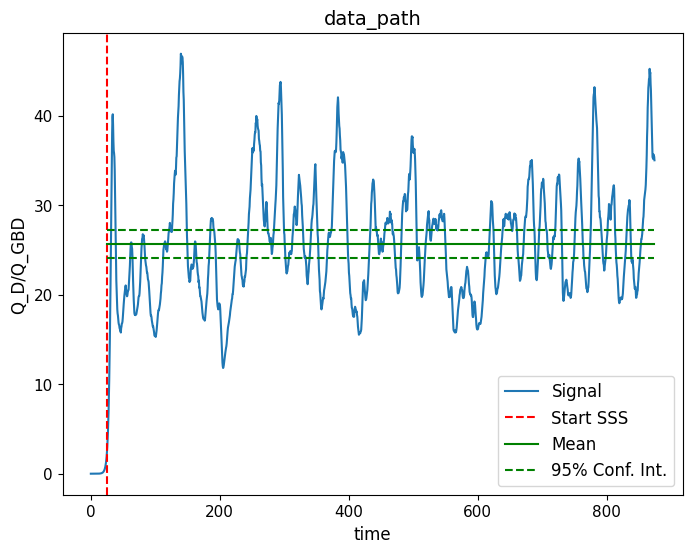

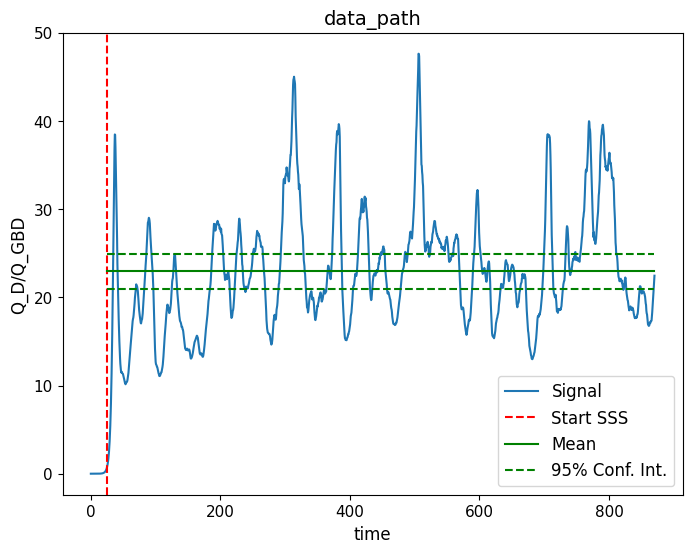

In [ ]:
# Process data streams with a more robust "workflow function"
flux_means = np.empty((len(data_paths),),dtype=float)
flux_unc   = np.empty((len(data_paths),),dtype=float)

for i_data, data_path in enumerate(data_paths):
    # Load the data into a data_stream object
    data_stream = qnds.from_csv(data_path)
    
    # Get statistics, set operate_safe to False so it will process 
    # data that is not stationary
    stats = process_data_steam(data_stream,col,operate_safe=False)

    # Print results
    print(f"Results for {data_path}:") 
    formatter.pprint(stats)

    # Plot trace with mean and start of steady state
    if not stats[col]["metadata"]["mitigation"] == "drop":
        plot_signal_basic_stats(data_stream,col,stats,label=data_path)

    # gather mean and uncertainties
    flux_means[i_data] = stats[col]["mean"]
    flux_unc[i_data]   = stats[col]["mean_uncertainty"]



In [7]:
flux_means

array([ 37.63888804,  38.02679835, 104.79143743,  35.7528207 ,
        25.63855344,  22.97844219])